In [1]:
import sqlite3
import pandas as pd
import ast
import numpy as np
from datetime import datetime

In [2]:
con = sqlite3.connect('cademycode.db')
cur = con.cursor()

In [3]:
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


In [4]:
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
career_paths = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

In [5]:
print('students: ', len(students))
print('career_paths: ', len(career_paths))
print('student_jobs: ', len(student_jobs))

students:  5000
career_paths:  10
student_jobs:  13


## Working with the `Students` table

Looking at the head of the table:

In [6]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


`contact_info` has a JSON format, might be a good idea to look into this later. Let's look at column data types:

In [7]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


We can see there is missing data in the last 4 columns of the dataframe. We have to make sure that `dob` is in datetime format that we can use to determine each student's age for better grouping. Numerical columns should be either integers or floats. We can also treat `job_id` and `current_career_path_id` as categorical data.

In [8]:
students[students.isnull().any(axis=1)]

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
15,16,Norene Dalton,1976-04-30,F,"{""mailing_address"": ""130 Wishing Essex, Branch...",6.0,0.0,None,None
19,20,Sofia van Steenbergen,1990-02-21,N,"{""mailing_address"": ""634 Clear Barn Dell, Beam...",7.0,13.0,None,None
25,26,Doug Browning,1970-06-08,M,"{""mailing_address"": ""P.O. Box 15845, Devine, F...",7.0,None,5.0,1.92
26,27,Damon Schrauwen,1953-10-31,M,"{""mailing_address"": ""P.O. Box 84659, Maben, Ge...",4.0,None,10.0,3.73
30,31,Christoper Warner,1989-12-28,M,"{""mailing_address"": ""556 Stony Highlands, Drai...",2.0,5.0,None,None
...,...,...,...,...,...,...,...,...,...
4948,4949,Dewitt van Malsem,1949-03-08,M,"{""mailing_address"": ""423 Course Trail, Wilmot,...",4.0,7.0,None,None
4956,4957,Todd Stamhuis,1961-06-15,M,"{""mailing_address"": ""251 Grand Rose Underpass,...",7.0,8.0,None,None
4974,4975,Jorge Creelman,1944-11-24,M,"{""mailing_address"": ""919 Well Overpass, Linden...",2.0,15.0,None,None
4980,4981,Brice Franklin,1946-12-01,M,"{""mailing_address"": ""947 Panda Way, New Bedfor...",4.0,None,5.0,8.66


No pattern can be found, we can only tell that there are 707 rows that have AT LEAST ONE null value in their columns.

### Calculating approximate age

To create an `age` column within our dataframe, we will have to use the `pd.to_datetime` function. We will also create an `age_group` column that should help us better classify our students.

In [9]:
now = datetime.now()
students['age'] = (now - pd.to_datetime(students['dob'])).dt.days // 365
students['age_group'] = (students['age'] // 10)*10
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,80,80
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,32,30
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,33,30
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,35,30
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,60,60


### Explode the dictionary

Now we need to extract all the information from the ``contact_info`` column so we can have an individual column for each key from the dictionary. First, let's take a look at the data type for said column:

In [10]:
type(students['contact_info'][0])

str

Notice how this column is made up of strings rather than dictionaries. We need to transform this column into dictionaries in order to extract the info with the help of `pd.json_normalize`. Here is how we can implement this:

In [11]:
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))

Now that we have transformed our `contact_info` column into a set of dictionaries, we can extract the information with the following methods:

In [12]:
explode_contact_info = pd.json_normalize(students['contact_info'])
explode_contact_info.head()

,mailing_address,email
0,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


We proceed to concatenate this dataframe with our original `students` dataframe:

In [13]:
students = pd.concat([students.drop('contact_info', axis=1), explode_contact_info], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,80,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32,30,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33,30,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,35,30,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,60,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


We will further split our `contact_info` to extract more bits of information for each student. Notice how `mailing_address` contains street name, city, state, and zip code. This is valuable information that the analytics team might want to explore further.

In [14]:
split_address = students.mailing_address.str.split(',', expand=True)
split_address.columns = ['street', 'city', 'state', 'zip_code']
split_address.head()

,street,city,state,zip_code
0,303 N Timber Key,Irondale,Wisconsin,84736
1,767 Crescent Fair,Shoals,Indiana,37439
2,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,18 Cinder Cliff,Doyles borough,Rhode Island,73737


Now, we will include this dataframe into our `students` dataframe and drop the `mailing_address` column in the process.

In [15]:
students = pd.concat([students.drop('mailing_address', axis=1), split_address], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,80,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,35,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,60,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


We will now take a look at our data types:

In [16]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   job_id                  4995 non-null   object
 5   num_course_taken        4749 non-null   object
 6   current_career_path_id  4529 non-null   object
 7   time_spent_hrs          4529 non-null   object
 8   age                     5000 non-null   int64 
 9   age_group               5000 non-null   int64 
 10  email                   5000 non-null   object
 11  street                  5000 non-null   object
 12  city                    5000 non-null   object
 13  state                   5000 non-null   object
 14  zip_code                5000 non-null   object
dtypes: i

### Fixing column data types

We want to change the data type for certain columns so we can use them for analysis down the line. We know that `num_course_taken` should be an integer value, and `time_spent_hrs` should be a float. Since there is some null data for `job_id` and `current_career_path_id`, we have to cast them into floats instead of integers for the time being.

In [17]:
students['job_id'] = students['job_id'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float)
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   job_id                  4995 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4529 non-null   float64
 7   time_spent_hrs          4529 non-null   float64
 8   age                     5000 non-null   int64  
 9   age_group               5000 non-null   int64  
 10  email                   5000 non-null   object 
 11  street                  5000 non-null   object 
 12  city                    5000 non-null   object 
 13  state                   5000 non-null   object 
 14  zip_code                5000 non-null   

### Handling missing data

Let's examine the missing data for `job_id`, `num_course_taken`, `current_career_path_id` and `time_spent_hrs` one by one.

In [18]:
missing_course_taken = students[students[['num_course_taken']].isnull().any(axis=1)]
display(missing_course_taken)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,53,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,70,70,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,46,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,61,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,39,30,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,5.0,NaN,8.0,22.75,53,50,tegan130@inlook.com,106 Sunny Nook,Vernal,Georgia,10769
4898,4899,Ruthann Oliver,1998-05-22,F,3.0,NaN,7.0,21.27,25,20,ruthann1124@woohoo.com,644 Merry Island,Green Valley,Wyoming,91273
4914,4915,Ernest Holmes,1995-03-11,M,7.0,NaN,9.0,26.50,28,20,ernest_holmes505@hmail.com,872 Wintergreen Harbor,Gallitzin borough,Maine,50103
4980,4981,Brice Franklin,1946-12-01,M,4.0,NaN,5.0,8.66,76,70,brice9741@coldmail.com,947 Panda Way,New Bedford village,Vermont,31232


Let's look at the distributions of the missing and complete data for `num_course_taken` side by side. If both distributions look similar, we can conclude that the data is missing at random if there is no identifiable pattern.

<Axes: xlabel='sex'>

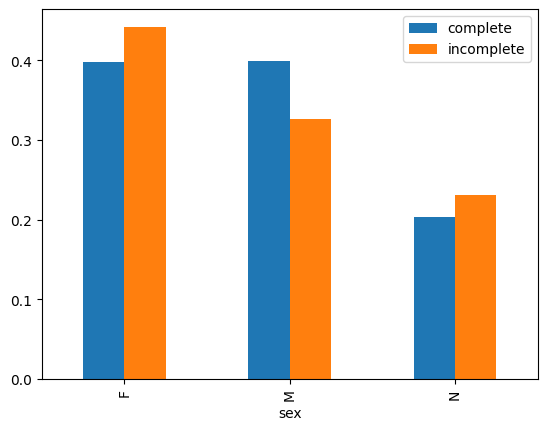

In [19]:
students_group = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
missing_group = (missing_course_taken.groupby('sex').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([students_group, missing_group], axis=1)
df.plot.bar()

<Axes: xlabel='job_id'>

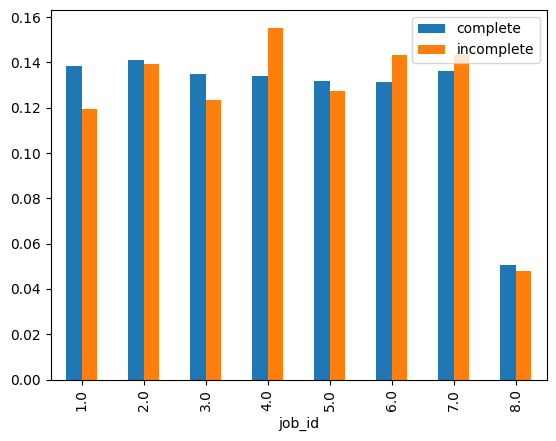

In [20]:
students_group = (students.groupby('job_id').count()['uuid']/len(students)).rename('complete')
missing_group = (missing_course_taken.groupby('job_id').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([students_group, missing_group], axis=1)
df.plot.bar()

<Axes: xlabel='age_group'>

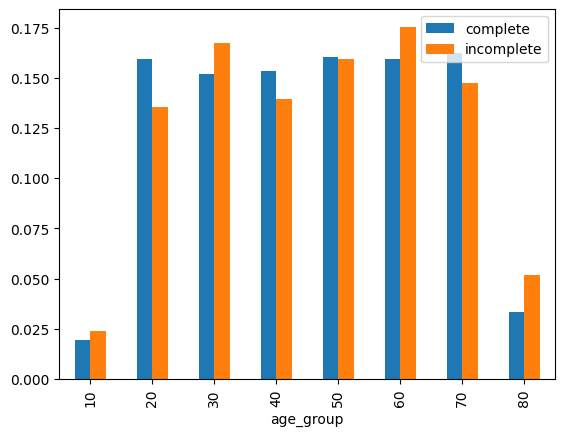

In [21]:
students_group = (students.groupby('age_group').count()['uuid']/len(students)).rename('complete')
missing_group = (missing_course_taken.groupby('age_group').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([students_group, missing_group], axis=1)
df.plot.bar()

By looking at the distributions side-by-side, we can see that they share some similarities. This means we can conclude that the data for `num_course_taken` is missing at random, since there is not identifiable pattern for all these distributions.

Now, we don't want to remove this data completely. Instead, we are going to store it in an alternate DataFrame and remove it from the main one since it accounts for less than 5% of the data. The reason to keep this information apart is that perhaps the analytics team might want to look into it with more detail.

In [22]:
missing_data = pd.DataFrame()
missing_data = pd.concat([missing_data, missing_course_taken])
students = students.dropna(subset=['num_course_taken'])
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4749 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4749 non-null   int64  
 1   name                    4749 non-null   object 
 2   dob                     4749 non-null   object 
 3   sex                     4749 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4298 non-null   float64
 7   time_spent_hrs          4298 non-null   float64
 8   age                     4749 non-null   int64  
 9   age_group               4749 non-null   int64  
 10  email                   4749 non-null   object 
 11  street                  4749 non-null   object 
 12  city                    4749 non-null   object 
 13  state                   4749 non-null   object 
 14  zip_code                4749 non-null   objec

Now we want to look into the `job_id`. It is important to note that this data is categorical and we also cannot impute it. Let's take a look at what we are dealing with in terms of missing data.

In [23]:
missing_job_id = students[students[['job_id']].isnull().any(axis=1)]
display(missing_job_id)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,21,20,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,21,20,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,21,20,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,21,20,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,21,20,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


Only 5 missing rows. Sample is too small compared to the total amount of data, so we can safely remove it from the Dataframe. We are going to store it in our `missing_data` df and drop it from the original one.

In [24]:
missing_data = pd.concat([missing_data, missing_job_id])
students = students.dropna(subset=['job_id'])
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4293 non-null   float64
 7   time_spent_hrs          4293 non-null   float64
 8   age                     4744 non-null   int64  
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   objec

For `current_career_path_id`, let's look at how much data we are missing.

In [25]:
missing_path_id = students[students[['current_career_path_id']].isnull().any(axis=1)]
display(missing_path_id)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,47,40,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,33,30,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,33,30,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,27,20,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,68,60,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,4905,Eduardo Daniel,2004-06-18,M,8.0,12.0,NaN,NaN,19,10,daniel5073@inlook.com,598 Deer Trace,Forest Grove,North Carolina,45038
4922,4923,Francisco van Ede,1961-04-26,M,7.0,5.0,NaN,NaN,62,60,vanede7845@coldmail.com,282 Fourth Trace,Carter Lake,Ohio,63511
4948,4949,Dewitt van Malsem,1949-03-08,M,4.0,7.0,NaN,NaN,74,70,dewitt4635@inlook.com,423 Course Trail,Wilmot,Hawaii,18996
4956,4957,Todd Stamhuis,1961-06-15,M,7.0,8.0,NaN,NaN,62,60,todd8019@woohoo.com,251 Grand Rose Underpass,Niagara,Pennsylvania,03430


We can see that `current_career_path_id` and `time_spent_hrs` are missing in the same instances since students are not enrolled in any career paths, and therefore not taking any classes. Let's run the following to be certain.

In [26]:
missing_path_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 451 entries, 15 to 4974
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    451 non-null    int64  
 1   name                    451 non-null    object 
 2   dob                     451 non-null    object 
 3   sex                     451 non-null    object 
 4   job_id                  451 non-null    float64
 5   num_course_taken        451 non-null    float64
 6   current_career_path_id  0 non-null      float64
 7   time_spent_hrs          0 non-null      float64
 8   age                     451 non-null    int64  
 9   age_group               451 non-null    int64  
 10  email                   451 non-null    object 
 11  street                  451 non-null    object 
 12  city                    451 non-null    object 
 13  state                   451 non-null    object 
 14  zip_code                451 non-null    objec

Since the amount of data is more than 5%, we would assign a new category for people with missing `current_career_path_id` and their `time_spent_hrs` will be set to 0, since they are not taking any classes.

In [28]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [29]:
students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   int64  
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   objec

### Working with the `career_paths` table

In [30]:
display(career_paths)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15
